# TODO
1. Pick a dataset
2. DOWNLOAD the dataset
3. Import using PyTorch
4. Explore the dataset for training
5. Move the dataset to GPU
6. Define a Neural Network
7. Prepare it for training
8. Make predicitons on sample images

Iterate on it with different Networks & Hyperparameter.

## Download the dataset
https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

In [2]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [3]:
ds_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [4]:
od.download(ds_url)

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


In [5]:
data_dir = './flowers-recognition/flowers'

In [6]:
import os
os.listdir(data_dir)

['dandelion', 'tulip', 'rose', 'daisy', 'sunflower']

### How many members do each class have?

In [7]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

dandelion : 1052
tulip : 984
rose : 784
daisy : 764
sunflower : 733


## Import the Dataset into PyTorch
1. Use the `ImageFolder` class from `torchvision`. 

In [8]:
from torchvision.datasets import ImageFolder

In [9]:
ds = ImageFolder(data_dir)

In [10]:
len(ds)

4317

In [11]:
ds[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F0BFF00DA90>, 0)

In [12]:
ds.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

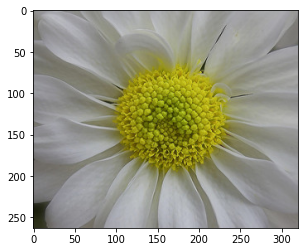

In [14]:
img, label = ds[0]
plt.imshow(img)

In [15]:
import torchvision.transforms as tt
ds = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                      tt.RandomCrop(64),
                                      tt.ToTensor()]))

In [16]:
# img, label = ds[0]
# plt.imshow(img)

The above line of code throws TypeError as the input needs channel as last dimension i.e., (224,224,3) and not (3,224,224)

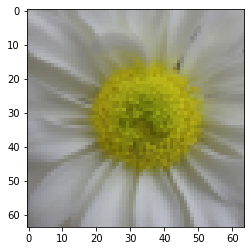

In [17]:
img, label = ds[0]
plt.imshow(img.permute((1,2,0)))

In [18]:
val_pct = 0.1                 # Validation Percentage
val_size = val_pct * len(ds)  # Validation Size
train_size = len(ds) - val_size
train_size, val_size

(3885.3, 431.70000000000005)

In [19]:
val_pct = 0.1                     # Validation Percentage
val_size = int(val_pct * len(ds)) # Validation Size
train_size = len(ds) - val_size
train_size, val_size

(3886, 431)

In [20]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(ds, [train_size, val_size])
len(train_ds), len(val_ds)

(3886, 431)

In [21]:
batch_size = 128

from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

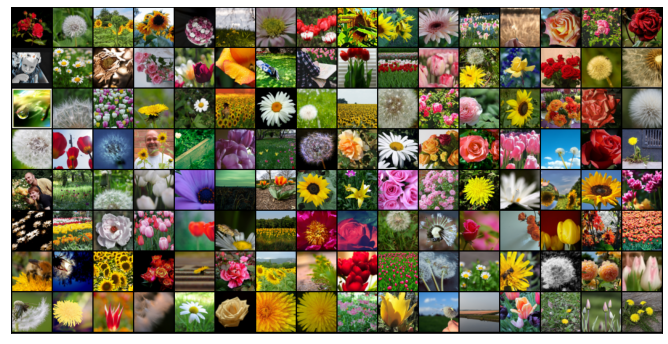

In [23]:
show_batch(train_dl) # will show a batch of the training dataloader

### GPU Utilities

In [24]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
torch.cuda.is_available()

True

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
img, label = ds[0]
img.device

device(type='cpu')

In [28]:
# Bydefault its on CPU so we have to change it
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [29]:
# Wrapping the training dataloader with the device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### Model & Training Utilities

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):    
      # Calculate Loss for a batch of Training data
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):       
      # Calculate Loss & Accuracy for a batch of Validation data
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
  # Evaluates the model's Performance on the Validation dataset
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [32]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input : 128 x 3 x 64 x 64
        
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [33]:
model = to_device(ResNet9(3,len(ds.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [34]:
model.conv1[0].weight.device

device(type='cuda', index=0)

First we will try to pass one batch of input tensor through the model.

In [35]:
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


The above line of code was throwing an error of `memory error`, we can reduce the `batch_size` or we can reduce the `tensor size` from **224** to **64**.

### Training the Model

In [36]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.6111338138580322, 'val_acc': 0.25914227962493896}]

In [37]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4855, val_loss: 1.3614, val_acc: 0.4122
Epoch [1], train_loss: 1.0729, val_loss: 0.9086, val_acc: 0.6339
Epoch [2], train_loss: 0.9282, val_loss: 0.8050, val_acc: 0.6876
Epoch [3], train_loss: 0.8207, val_loss: 0.7053, val_acc: 0.7359
Epoch [4], train_loss: 0.7427, val_loss: 0.8050, val_acc: 0.7126


In [38]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5921, val_loss: 0.6308, val_acc: 0.7609
Epoch [1], train_loss: 0.5442, val_loss: 0.6468, val_acc: 0.7517
Epoch [2], train_loss: 0.5205, val_loss: 0.6148, val_acc: 0.7693
Epoch [3], train_loss: 0.4800, val_loss: 0.5265, val_acc: 0.8157
Epoch [4], train_loss: 0.4653, val_loss: 0.5506, val_acc: 0.7847


In [39]:
history += fit(5, 0.0001, model, train_dl, val_dl) # Using torch.optim.SGD which is the default

Epoch [0], train_loss: 0.4230, val_loss: 0.5397, val_acc: 0.7989
Epoch [1], train_loss: 0.4240, val_loss: 0.5340, val_acc: 0.8081
Epoch [2], train_loss: 0.4162, val_loss: 0.5346, val_acc: 0.7984
Epoch [3], train_loss: 0.4157, val_loss: 0.5053, val_acc: 0.8163
Epoch [4], train_loss: 0.4251, val_loss: 0.5312, val_acc: 0.8062


Within a minute we get the accuracy from 16% to 74%, then from 74% to 79%. If one epoch is taking more than 2-3 mins then change the `batch_size`, use `small datasets`, etc and try to reduce the runtime.

In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

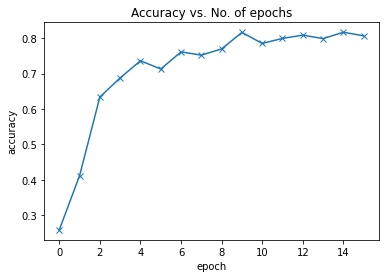

In [41]:
plot_accuracies(history)

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

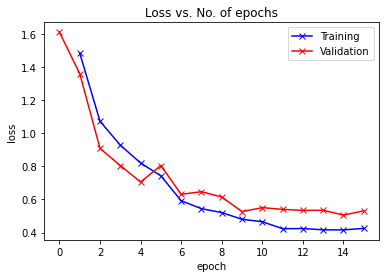

In [43]:
plot_losses(history)

Overfitting occurs when the `Validation Loss` starts to increase and the `Training Loss` starts to decrease.

In [44]:
!pip install jovian --upgrade --quiet
import jovian

In [45]:
jovian.reset()
jovian.log_dataset(image_size=64,
                   arch='ResNet9',
                   epoch=[5,5,5],
                   lrs=[0.001, 0.0001, 0.0001],
                   opt=['Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_loss=history[-1]['val_loss'],
                   val_acc=history[-1]['val_acc'])

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Dataset logged.
[jovian] Metrics logged.


In [46]:
jovian.commit(project='deep-learning-project-live')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Testing with Individual Images

In [47]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [52]:
def predictions(num):
  img, label = val_ds[num]
  plt.imshow(img.permute(1,2,0))
  pred = predict_image(img, model, ds.classes)
  print('Target :', ds.classes[label])
  print('Prediction :', pred)

Target : tulip
Prediction : tulip


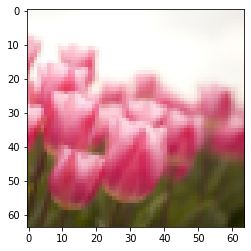

In [53]:
predictions(0)

Target : dandelion
Prediction : dandelion


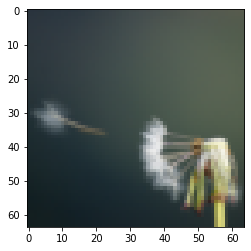

In [54]:
predictions(11)

Target : daisy
Prediction : daisy


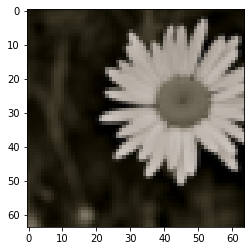

In [55]:
predictions(150)

In [56]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')

In [57]:
jovian.commit(project='deep-learning-project-live',
              outputs=['flowe-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Transfer Learning

In [58]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [78]:
model = to_device(ResNet34(len(ds.classes), pretrained=True), device)

In [79]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

ds = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                      tt.RandomCrop(img_size),
                                      tt.ToTensor(),
                                      tt.Normalize(*imagenet_stats)]))

In [80]:
batch_size = 64

train_ds, val_ds = random_split(ds, [train_size, val_size])
len(train_ds), len(val_ds)

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

In [81]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [82]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [83]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.6496506929397583, 'val_acc': 0.23128798604011536}]

In [84]:
history += fit_one_cycle(5, 0.001, model, train_dl, val_dl,
               weight_decay=0.01, grad_clip=0.1, opt_func=torch.optim.Adam)

  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.5334, val_loss: 1.0270, val_acc: 0.7119


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.7565, val_loss: 0.9370, val_acc: 0.6717


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6157, val_loss: 0.7016, val_acc: 0.7850


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.4208, val_loss: 0.4087, val_acc: 0.8409


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2881, val_loss: 0.3084, val_acc: 0.8811


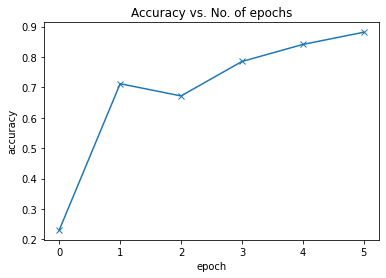

In [86]:
plot_accuracies(history)

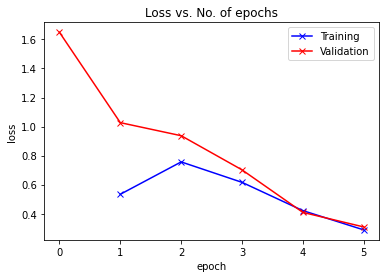

In [87]:
plot_losses(history)

In [90]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', ds.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

def predictions_2(num):
  img, label= val_ds[num]
  show_image(img, label)
  pred = predict_image(img, model, ds.classes)
  print('Prediction :', pred)

Label: dandelion (1)
Prediction : dandelion


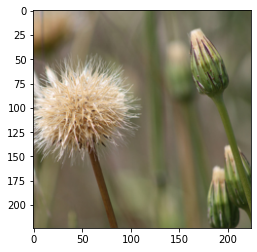

In [92]:
predictions_2(0)

Label: tulip (4)
Prediction : tulip


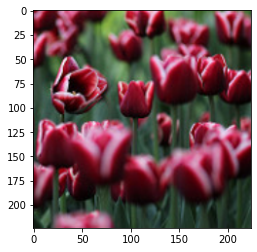

In [93]:
predictions_2(10)

Label: rose (2)
Prediction : rose


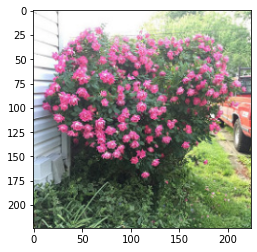

In [94]:
predictions_2(30)

Label: tulip (4)
Prediction : rose


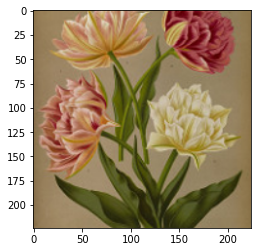

In [95]:
predictions_2(123)

In [96]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
